<a href="https://colab.research.google.com/github/vigneshdurairaj/EURO-to-INR-exchange-rate-prediction-using-LSTM/blob/master/EURO_to_INR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Euro to Inr Exchange rate prediciton using LSTM**

In [0]:
#import necessary package
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from keras import optimizers
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM
import keras.backend as K

import tqdm

**Dataset**
The dataset was collected from https://in.investing.com/currencies/eur-inr-historical-data. Create an account and download the dataset or just go to my github repository to collect the dataset.

In [0]:
a = pd.read_csv('euro_to_inr.csv')

In [136]:
df = a[['date', 'price']]
df.columns = ['date', 'price']
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')
df = df.sort_values(by='date')
# df = df.reset_index(drop=True)
df.tail()

,price
date,
2019-10-13,78.460121
2019-10-14,78.441849
2019-10-15,78.597847
2019-10-16,78.579704
2019-10-17,78.734657


In [137]:
df.iloc[3500]

price    67.592
Name: 2015-04-19 00:00:00, dtype: float64

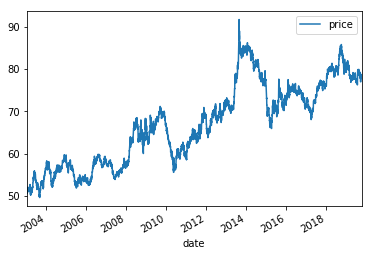

In [138]:
df.plot()

In [0]:
split_date = pd.Timestamp('2015-04-19')

In [0]:
train = df.loc[:split_date, ['price']]
test = df.loc[split_date:, ['price']]

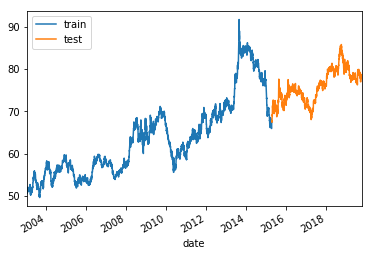

In [141]:
ax = train.plot()
test.plot(ax=ax)
plt.legend(['train', 'test'])

In [0]:
sc = MinMaxScaler()

train_sc = sc.fit_transform(train)
test_sc = sc.transform(test)

In [143]:
train_sc[:4]

array([[0.02659209],
       [0.02197047],
       [0.02290664],
       [0.02295404]])

In [144]:
train[:4]

,price
date,
2003-01-10,50.7115
2003-01-13,50.5165
2003-01-14,50.5560
2003-01-15,50.5580


In [0]:
X_train = train_sc[:-1]
y_train = train_sc[1:]

X_test = test_sc[:-1]
y_test = test_sc[1:]

In [146]:
train_sc.shape

(3501, 1)

In [147]:
y_train

array([[0.02197047],
       [0.02290664],
       [0.02295404],
       ...,
       [0.41413268],
       [0.4268125 ],
       [0.4266703 ]])

In [0]:
X_train_t = X_train[:, None]
X_test_t = X_test[:, None]

In [149]:
X_train_t.shape

(3500, 1, 1)

In [0]:
num_units = 4
activation_function = 'sigmoid'
optimizer = 'adam'
loss_function = 'mean_squared_error'
batch_size = 60
num_epochs = 75

# Initialize the RNN
regressor = Sequential()

# Adding the input layer and the LSTM layer
regressor.add(LSTM(units = num_units, activation = activation_function, input_shape=(1, 1)))

# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = optimizer, loss = loss_function)

# Using the training set to train the model


In [153]:
regressor.fit(X_train_t, y_train, batch_size = batch_size, epochs = num_epochs)

Epoch 1/75
3500/3500 [==============================] - 12s 4ms/step - loss: 0.4407
Epoch 2/75
3500/3500 [==============================] - 0s 47us/step - loss: 0.2906
Epoch 3/75
3500/3500 [==============================] - 0s 48us/step - loss: 0.1902
Epoch 4/75
3500/3500 [==============================] - 0s 51us/step - loss: 0.1262
Epoch 5/75
3500/3500 [==============================] - 0s 52us/step - loss: 0.0875
Epoch 6/75
3500/3500 [==============================] - 0s 49us/step - loss: 0.0653
Epoch 7/75
3500/3500 [==============================] - 0s 49us/step - loss: 0.0534
Epoch 8/75
3500/3500 [==============================] - 0s 50us/step - loss: 0.0474
Epoch 9/75
3500/3500 [==============================] - 0s 47us/step - loss: 0.0446
Epoch 10/75
3500/3500 [==============================] - 0s 49us/step - loss: 0.0431
Epoch 11/75
3500/3500 [==============================] - 0s 49us/step - loss: 0.0422
Epoch 12/75
3500/3500 [==============================] - 0s 49us/step - lo

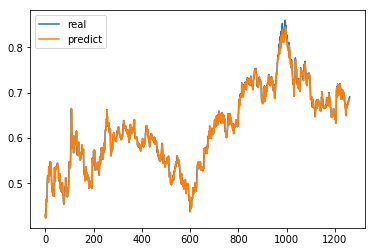

In [154]:
y_pred = regressor.predict(X_test_t)
plt.figure()
plt.plot(y_test)
plt.plot(y_pred)
plt.legend(['real', 'predict'])

In [0]:
regressor.save('model.h5')


In [0]:
from keras.models import load_model
def predict_torrmow():
    model = load_model('model.h5')



    train = df[["price"]]
    sc = MinMaxScaler()

    train_sc = sc.fit_transform(train)
    X_train = train_sc[:-1]
    y_train = train_sc[1:]
    X_train_t = X_train[:, None]

    y_pred = model.predict(X_train_t)
    result = sc.inverse_transform(y_pred)[-2:]
    today = result[0][0]
    tomorrow =result[1][0]
    output = "flat"
    if tomorrow > today:
        output = "up"
    elif tomorrow < today:
        output = "down"
    return output, tomorrow

In [157]:
for i in range(30):

  sign, price = predict_torrmow()
  print(sign,price)

  x = pd.DatetimeIndex(df.iloc[-1:].index.values) + pd.DateOffset(1)
  ts = pd.to_datetime(x[0])
  tomorrow = ts.strftime('%Y-%m-%d')

  new_df = pd.DataFrame([[tomorrow,price]],columns=["date","price"])
  new_df['date'] = pd.to_datetime(new_df['date'])
  new_df = new_df.set_index('date')

  df = df.append(new_df)
  df["price"] = df["price"].astype(float)
  df.to_csv("data.csv")
  new_df_predict = pd.DataFrame([[tomorrow, sign, price]], columns=["date","trend","price"])
  df_predict = pd.read_csv("data_predicted.csv")
  check_date = pd.DatetimeIndex(df_predict.iloc[-1:]["date"].values).strftime('%Y-%m-%d')[0]
  try:
      days = df.iloc[df.index.get_loc(check_date)-1: df.index.get_loc(check_date)+1]
  except:
      days = df.iloc[-2:]
  today_price = days.iloc[1]["price"]
  yesterday_price = days.iloc[0]["price"]
  real_sign = "flat"
  if today_price > yesterday_price:
      real_sign = "up"
  elif today_price < yesterday_price:
      real_sign = "down"
  df_predict = df_predict.append(new_df_predict, ignore_index=True)
  df_predict.to_csv("data_predicted.csv", index=False)

down 78.54002


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


up 78.69359


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


down 78.5007


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


up 78.65289


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


down 78.46173


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


up 78.612564


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


down 78.423096


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


up 78.57259


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


down 78.384796


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


up 78.53298


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


down 78.34683


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


up 78.49372


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


down 78.3092


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


up 78.4548


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


down 78.27188


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


up 78.41623


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


down 78.23488


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


up 78.37799


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


down 78.19819


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


up 78.34009


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


down 78.161804


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


up 78.3025


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


down 78.125725


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


up 78.26524


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


down 78.08995


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


up 78.2283


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


down 78.054474


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


up 78.191666


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


down 78.01928


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


up 78.155334


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [159]:
df.tail(10)

,price
date,
2019-11-07,78.161804
2019-11-08,78.302498
2019-11-09,78.125725
2019-11-10,78.265244
2019-11-11,78.089951
2019-11-12,78.228302
2019-11-13,78.054474
2019-11-14,78.191666
2019-11-15,78.019279


In [158]:
df_predict

,Unnamed: 0,date,price,trend
0,0.0,2019-10-16,78.579704,down
1,NaN,2019-10-17,78.734657,up
2,NaN,2019-10-18,78.540024,down
3,NaN,2019-10-19,78.693588,up
4,NaN,2019-10-20,78.500702,down
5,NaN,2019-10-21,78.652893,up
6,NaN,2019-10-22,78.461731,down
7,NaN,2019-10-23,78.612564,up
8,NaN,2019-10-24,78.423096,down
9,NaN,2019-10-25,78.572594,up
